# Corn Segmentation

We first import the necessary packages. For this to run you need to install `scikit-image`, `matplotlib`, and `numpy`.

In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt 
from plantcv import plantcv as pcv
import pandas as pd

import skimage
from skimage.measure import regionprops
from skimage.segmentation import felzenszwalb, slic, mark_boundaries

# Make images bigger
plt.rcParams['figure.figsize'] = [15, 12]

We now load an example image. They are located in the `test_imgs` directory. We further normalize the pixels in the image to be in the range [0, 1]. 

In [27]:
file_name = os.path.join("test_imgs", "IMG_0001.JPG")
img = skimage.io.imread(file_name)
# img = skimage.util.img_as_float(img[::2, ::2]) # Normalize btwn [0, 1]
img = skimage.util.img_as_float(img)

f"Image '{file_name}' loaded!"

"Image 'test_imgs/IMG_0001.JPG' loaded!"

The first step to extracting the corn is to apply a segmentation algorithm. This will divide the image into a number of segments. Our goal is to ensure that one of those clusters is the corn.

We attempt to do this using K-Means clustering. This produces the segments by grouping areas of the image that are similar in proximity and color. This is done using the `slic` function. Below is the image separated by the segment boundaries.

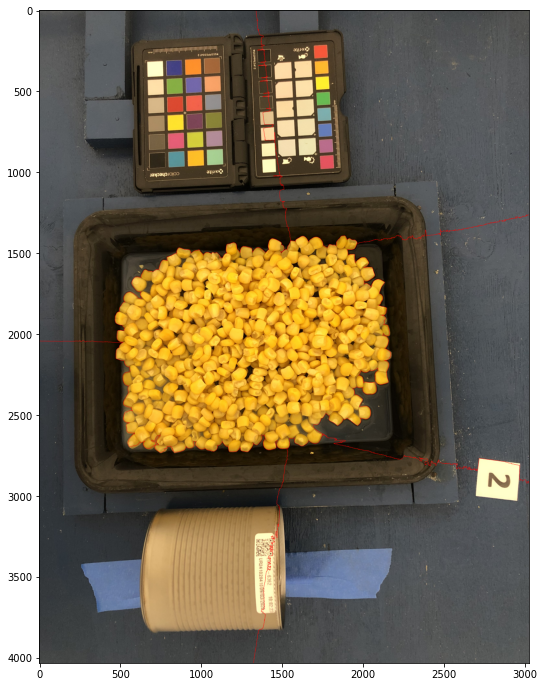

In [28]:
# Apply K-means
img_with_segments = slic(img, n_segments=5, convert2lab=True, compactness=100)

# Show the image with the boundaries
plt.imshow(mark_boundaries(img, img_with_segments, color=(1, 0, 0)))
plt.show()

In order to identify the segment that contains the corn, we rely on an assumption. That assumption is that segment with the corn will be the centermost segment in the image. Assuming the data collection process was consistent, this should be a reasonable assumption.

In order to do this we measure the distance from the center of the image to the center of each segment. This is done in the following steps:

1. Pass the segmented image (output of `slic`) to the `regionprops` function. This returns an object with the properties of each segment. The `centroid` attribute of each segment returned by this function contains the center position of each image.
2. Measure the euclidean distance between the center of each segment and the overall image. This is done using the `dist_from_img_center` function, which takes the segment and the original image as input.
3. We choose the segment with the smallest distance measured from the center of the image.

In [29]:
def dist_from_img_center(segment, img):
    """
    Return euclidean distance from center of image for segement

    Parameters:
    -----------
        segment: regionprops
            Region properties for segment
        img: np.array
            Original image
    
    Returns:
    --------
    float
        distance form segment to center of img
    """
    segment_center = np.array(segment.centroid)
    img_center = np.array([img.shape[0] / 2, img.shape[1] / 2]) 

    return np.linalg.norm(img_center - segment_center, 2)


# Measures distance of each cluster from center of image
segment_dists = [dist_from_img_center(prop, img) for prop in regionprops(img_with_segments)]

# Extract cluster closest to center
center_segment = np.argmin(segment_dists) + 1

f"The centermost segment is {center_segment}!"

'The centermost segment is 4!'

We now want to extract the identified segment of the image that we think identifies the corn. We do this by setting every other segment of the image equal to black.

We can now display the extracted segment and see how we did.

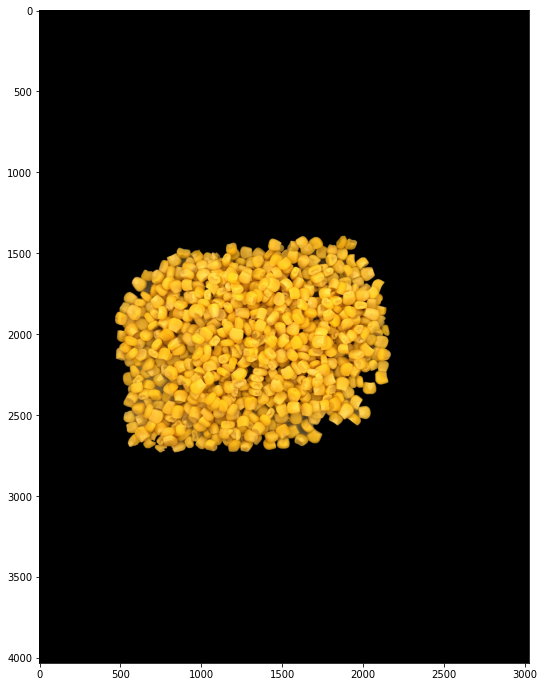

In [30]:
# 'img_with_segments' is just a matrix. we repeat it 3 times so it corresponds to a rgb image
img_with_segments_3d = np.repeat(img_with_segments[:, :, np.newaxis], 3, axis=2)

# Set everything besides center to black
center_mask = np.where(img_with_segments_3d == center_segment, 255, 0)

# Get mask
masked_image = pcv.apply_mask(img, center_mask, 'black')

# Display segmented portion
plt.imshow(masked_image)
plt.show()

Using the masked photograph of the corn, a histogram was created to decide how we would separate corn color. It was clear that the blue-yellow coloration was the best option.

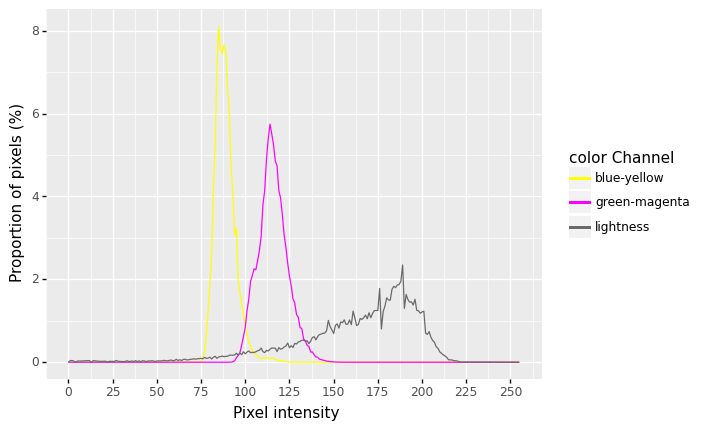

<ggplot: (8766232403685)>

In [31]:
from plantcv import plantcv as pcv

# Convert orignial image back to 0-255
if np.max(img) != 255:
    img = (img * 255).astype(np.uint8)

# Analyze color 
center_mask_2d = center_mask[:, :, 0].astype(np.uint8)

pcv.analyze_color(rgb_img=img, mask=center_mask_2d, hist_plot_type="lab")

Using the `rgb2lab` function, the image was changed from RGB values to LAB values. This enables us to analyze the different masked photos and separate out the different shades of yellow in the photographs. To ensure no black space was included, we only include values whose L value is greater than 0, since an L value of 0 denotes black.

In [35]:
img_lab = skimage.color.rgb2lab(img)

masked_img_lab = pcv.apply_mask(img_lab, center_mask, 'black')

# Only extract corn portion of Blue-Yellow channel
# center_mask_2d = 0 for black and > 0 otherwise
blue_yellow_channel = masked_img_lab[:, :, 2]
blue_yellow_just_corn = blue_yellow_channel[center_mask_2d > 0]
print(blue_yellow_just_corn)



<class 'numpy.ndarray'>
[41.63172245 42.65904421 42.65904421 ... 48.2914241  49.22979891
 50.78500192]


We found the mean, median, standard deviation and range to help us analyze the best way to "bin" different shades of yellow. 

In [38]:
mean_blue_yellow = np.mean(blue_yellow_just_corn)
print("Mean Blue-Yellow:", np.mean(blue_yellow_just_corn))
median_blue_yellow = np.median(blue_yellow_just_corn)
print("Median Blue-Yellow:", np.median(blue_yellow_just_corn))
std_blue_yellow = np.std(blue_yellow_just_corn)
print("Std Blue-Yellow:", np.std(blue_yellow_just_corn))
min_blue_yellow = np.min(blue_yellow_just_corn)
max_blue_yellow = np.max(blue_yellow_just_corn)
print(f"Range Blue-Yellow: {np.min(blue_yellow_just_corn)} to {np.max(blue_yellow_just_corn)}")

# TODO:
# 1. Break down into "N" bins
# 2. Get % of pixels in each bin
# 3. Store metrics for image 

Mean Blue-Yellow: 67.63947693527813
Median Blue-Yellow: 70.31066513325513
Std Blue-Yellow: 10.951091128726345
Range Blue-Yellow: -1.0924902151857152 to 85.65734818823097


We chose to bin the shades of yellow into 8 bins. In LAB values, A and B are usually clamped from -128 to 127. The B value is the yellow-blue value, where yellow would be 0 to 127. In order to separate yellow values into equal bins that will account for some variation in color we chose to separate the values into 8 bins. Each bin will represent 16 values.

#Create function that bins amount of yellow into different bins. This should be accomplished by: counting the number of pixels above 0 B value (yellow only), iterating over each pixel and increasing the count for a variable depending on the B value. Then each tally will be divided over the total number of pixels iterated through

In [42]:
# Sort the B values of the pixels so that counting the number of values in each bin is simpler 
blue_yellow_just_corn.sort()
x = len(blue_yellow_just_corn)
print(x)

# Change the blue_yellow_just_corn list into a series to make it easier to manipulate
bval_series = pd.Series(blue_yellow_just_corn)
# Create a list of ranges to separate the number of pixels by
bins = [0,16,32,48,64,80,96,112,128]
# Separate the number of pixels into 8 bins based on the values in the list "bins"
bin_val = bval_series.value_counts(bins=bins, sort=False)
print(bin_val)
percent= (bin_val/x) * 100
print(percent)

z = percent.index.tolist()
print(z)
"""From collections import default dict, create the dict names to be the ranges, the default dict will auto put
zeros where the defs go. organize the list of pixel values in number order, make into a series make series into a 
T, F matrix to add up the T numbers to put in the dict for specific range and iterate over 8 times to fill in 8 defs
of range with numbers. if bin is index, use reset index function - make the index number be 0 - 7, keep interval column
makes become df instead of series, specify drop as False"""



1829219
<class 'pandas.core.series.Series'>
(-0.001, 16.0]     0.552695
(16.0, 32.0]       1.140815
(32.0, 48.0]       3.429004
(48.0, 64.0]      21.505626
(64.0, 80.0]      70.343136
(80.0, 96.0]       3.028670
(96.0, 112.0]      0.000000
(112.0, 128.0]     0.000000
dtype: float64
[Interval(-0.001, 16.0, closed='right'), Interval(16.0, 32.0, closed='right'), Interval(32.0, 48.0, closed='right'), Interval(48.0, 64.0, closed='right'), Interval(64.0, 80.0, closed='right'), Interval(80.0, 96.0, closed='right'), Interval(96.0, 112.0, closed='right'), Interval(112.0, 128.0, closed='right')]


'From collections import default dict, create the dict names to be the ranges, the default dict will auto put\nzeros where the defs go. organize the list of pixel values in number order, make into a series make series into a \nT, F matrix to add up the T numbers to put in the dict for specific range and iterate over 8 times to fill in 8 defs\nof range with numbers. if bin is index, use reset index function - make the index number be 0 - 7, keep interval column\nmakes become df instead of series, specify drop as False'

Store the pic_data in 1 array
Store rating number in another array
Reference column between both is image name
Rating number is bin index+1
if statement - check if file name pic_data or grade exists. If not, make file. if is, add to file

In [44]:
# Getting the index of the bin with the largest amount of pixels 
bin_index = bin_val.argmax()
# Creating a grade from 1 - 8 for a photo based on the bin with the largest amount of pixels
grade = bin_index+1
print(bin_index)
print(grade)

4
5


In [50]:
# create grade df with img name and grade
# os.path.basename(path): takes only the file name of the image
grade_df = pd.DataFrame(np.array([[os.path.basename(file_name),grade]]),columns = ['Image', 'Grade'])

print(grade_df)
# putting series in df so easier to append into a csv
percent_df = percent.to_frame()
print(percent_df)

# Check if file exists


          Image Grade
0  IMG_0001.JPG     5
                        0
(-0.001, 16.0]   0.552695
(16.0, 32.0]     1.140815
(32.0, 48.0]     3.429004
(48.0, 64.0]    21.505626
(64.0, 80.0]    70.343136
(80.0, 96.0]     3.028670
(96.0, 112.0]    0.000000
(112.0, 128.0]   0.000000


In [47]:
#if os.path.exists("grade.csv") == True: 
    
#percent_df.to_csv('test.csv')